In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Load the Data

In [87]:
df = pd.read_csv('data/videos_featured.csv', sep=';')

### Step 2: Basic Checks

In [88]:
df.head() # View top rows

,video_id,title,published_at,views,likes,comments,duration_seconds,tags_array,published_us_est,published_year,published_month,published_quarter,published_weekday,published_hour,like_ratio,comment_ratio,published_time_of_day
0,DlEkWd-8VXA,250k Subscriber Live Stream!!,2022-07-26 13:19:48,4168,156,11,4539,"{""Alex The Analyst"",""Live Stream"",""250k subscr...",2022-07-26 09:19:48,2022,7,Q3,Tuesday,9,0.0374,0.0026,Morning
1,xb5-UX-jYw0,How to Lie with Data | Averages,2025-04-08 12:01:32,4150,216,14,407,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-04-08 08:01:32,2025,4,Q2,Tuesday,8,0.0520,0.0034,Morning
2,V3ouFOBQP0k,How to Lie with Data | Percentages and Baselin...,2025-04-01 12:00:46,4361,216,9,318,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-04-01 08:00:46,2025,4,Q2,Tuesday,8,0.0495,0.0021,Morning
3,oi9W142ELN0,1 Million YouTube Play Button Unboxing!,2025-03-25 12:01:10,3073,236,79,460,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-03-25 08:01:10,2025,3,Q1,Tuesday,8,0.0768,0.0257,Morning
4,5n52mlp9Ym0,Maven Analytics + Analyst Builder Lifetime Acc...,2025-03-24 12:00:07,8613,254,41,315,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-03-24 08:00:07,2025,3,Q1,Monday,8,0.0295,0.0048,Morning


In [89]:
df.shape # Check the number of rows and columns

(366, 17)

In [90]:
df.columns # Column names

Index(['video_id', 'title', 'published_at', 'views', 'likes', 'comments',
       'duration_seconds', 'tags_array', 'published_us_est', 'published_year',
       'published_month', 'published_quarter', 'published_weekday',
       'published_hour', 'like_ratio', 'comment_ratio',
       'published_time_of_day'],
      dtype='object')

In [91]:
df.dtypes # Check data type of each column

video_id                  object
title                     object
published_at              object
views                      int64
likes                      int64
comments                   int64
duration_seconds           int64
tags_array                object
published_us_est          object
published_year             int64
published_month            int64
published_quarter         object
published_weekday         object
published_hour             int64
like_ratio               float64
comment_ratio            float64
published_time_of_day     object
dtype: object

In [92]:
df.info() # Check nulls + types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   video_id               366 non-null    object 
 1   title                  366 non-null    object 
 2   published_at           366 non-null    object 
 3   views                  366 non-null    int64  
 4   likes                  366 non-null    int64  
 5   comments               366 non-null    int64  
 6   duration_seconds       366 non-null    int64  
 7   tags_array             366 non-null    object 
 8   published_us_est       366 non-null    object 
 9   published_year         366 non-null    int64  
 10  published_month        366 non-null    int64  
 11  published_quarter      366 non-null    object 
 12  published_weekday      366 non-null    object 
 13  published_hour         366 non-null    int64  
 14  like_ratio             366 non-null    float64
 15  commen

### 📊 Step 3: Descriptive Statistics

In [93]:
df.describe() # Summary for numeric columns

,views,likes,comments,duration_seconds,published_year,published_month,published_hour,like_ratio,comment_ratio
count,3.660000e+02,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1.390425e+05,3328.486339,180.199454,1700.691257,2022.297814,6.327869,8.341530,0.033302,0.003144
std,2.597877e+05,5760.090393,385.038146,4786.842221,1.570741,3.537144,2.555847,0.016346,0.005271
min,2.590000e+02,34.000000,3.000000,9.000000,2020.000000,1.000000,0.000000,0.012000,0.000200
25%,1.292150e+04,435.000000,30.000000,386.250000,2021.000000,3.000000,7.000000,0.021825,0.000800
50%,3.568100e+04,1332.500000,77.000000,721.000000,2022.000000,6.000000,8.000000,0.029550,0.001600
75%,1.397555e+05,3597.750000,161.750000,1581.500000,2024.000000,9.750000,9.000000,0.039300,0.003175
max,2.174630e+06,48329.000000,4370.000000,84768.000000,2025.000000,12.000000,23.000000,0.131300,0.063800


In [94]:
df['published_weekday'].value_counts() # Published total videos of each weekday

published_weekday
Tuesday      238
Thursday      55
Wednesday     28
Monday        19
Friday        17
Saturday       6
Sunday         3
Name: count, dtype: int64

In [95]:
df['published_hour'].value_counts() # Published total videos of each hour

published_hour
8     128
7      88
6      50
10     24
9      23
11     19
12     19
13      4
21      3
0       2
14      2
22      2
23      1
19      1
Name: count, dtype: int64

In [96]:
df['published_time_of_day'].value_counts() # Published total videos of each time of day

published_time_of_day
Morning          332
Afternoon         25
Evening            7
Early Morning      2
Name: count, dtype: int64

### Step 4: Visualize Distributions and Patterns

d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Views')

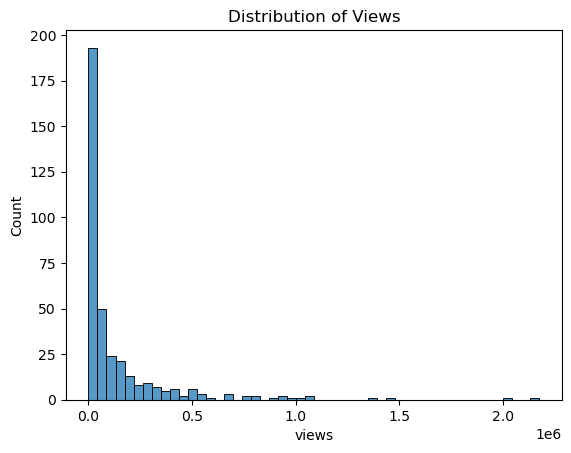

In [97]:
# Views distribution
sns.histplot(df['views'], bins=50)
plt.title("Distribution of Views")

Text(0.5, 1.0, 'Views along Published Weekday')

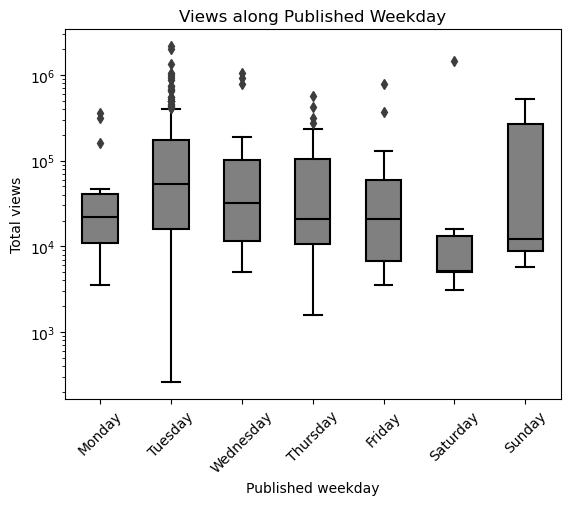

In [111]:
# Boxplot of views by weekday
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='published_weekday', y='views', data=df, order = weekday, showfliers=True, width=0.5,
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.ylabel('Total views')
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Published weekday')
plt.title("Views along Published Weekday")

**Insights**: Tuesday-Thursday videos tend to perform more consistently well. On Sundays, the video performance has high variance. Saturday is consistently underperforming.

Text(0.5, 1.0, 'Video Duration vs Like Ratio')

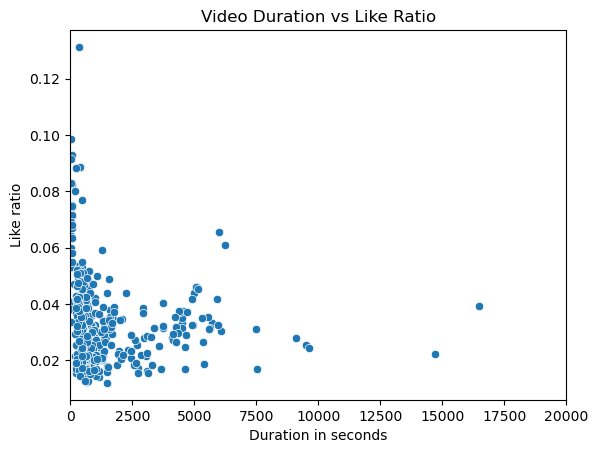

In [99]:
# Like ratio vs duration
sns.scatterplot(x='duration_seconds', y='like_ratio', data=df)
plt.xlim([0,20000])
plt.xlabel('Duration in seconds')
plt.ylabel('Like ratio')
plt.title("Video Duration vs Like Ratio")

Text(0.5, 1.0, 'Video Duration vs Like Ratio')

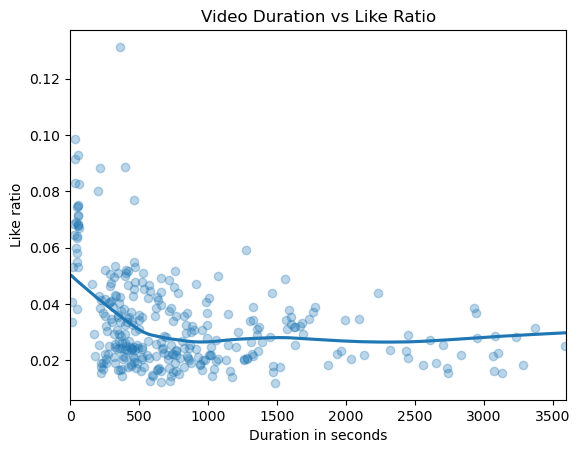

In [112]:
sns.regplot(x='duration_seconds', y='like_ratio', data=df, lowess=True, scatter_kws={'alpha': 0.3})
plt.xlim([0,3600])
plt.xlabel('Duration in seconds')
plt.ylabel('Like ratio')
plt.title("Video Duration vs Like Ratio")

### Step 5: Grouped Analysis (Trends)

Text(0.5, 1.0, 'Average Views by Time of Day')

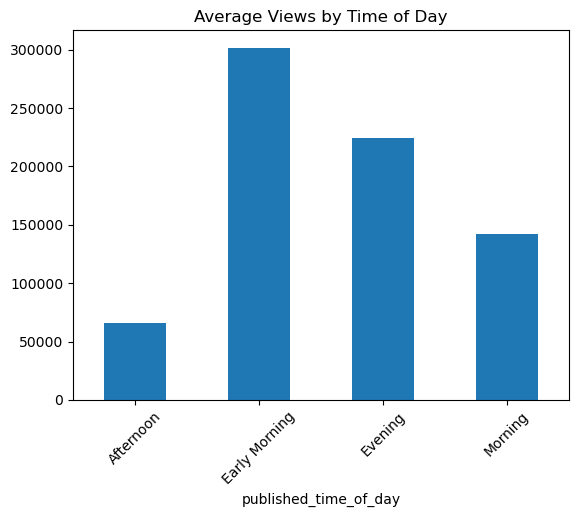

In [101]:
# Average views by time of day
df.groupby('published_time_of_day')['views'].mean().plot(kind='bar')
plt.xticks(rotation=45)
plt.title("Average Views by Time of Day")

In [102]:
# Engagement by weekday
df.groupby('published_weekday').agg({
    'views': 'mean',
    'likes': 'sum',
    'comments': 'sum'
}).sort_values(by='views', ascending=False)

,views,likes,comments
published_weekday,,,
Saturday,251124.000000,19686,2181
Sunday,180888.333333,7964,371
Tuesday,159199.050420,882380,43522
Wednesday,144940.214286,108437,5450
Friday,93169.235294,53486,2343
Thursday,75175.290909,113106,10518
Monday,61785.315789,33167,1568


### Step 6: Correlation Analysis

Text(0.5, 1.0, 'Correlation Heatmap')

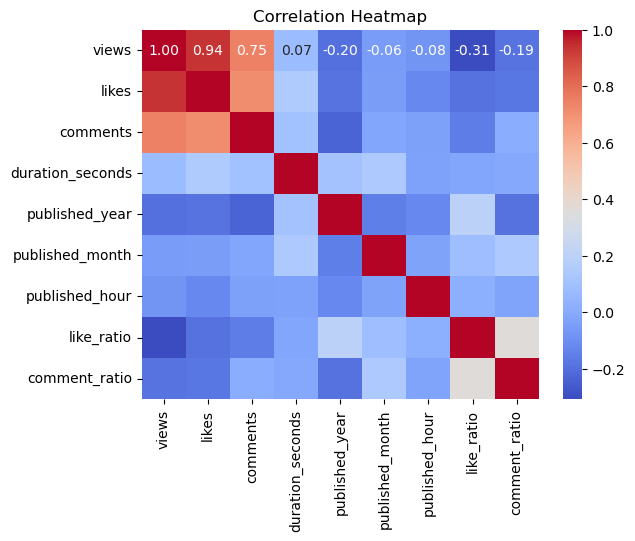

In [103]:
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")

### Step 7: Tag Exploration

In [104]:
from collections import Counter

tags_flat = df['tags_array'].dropna().explode()
tag_counts = Counter(tags_flat)
tag_counts.most_common(20)


[('{"Data Analyst","Data Analyst job","Data Analyst Career","Data Analytics","Alex The Analyst"}',
  112),
 ('{"Data Analyst","Data Analyst job","Data Analyst Career","Data Analytics","Alex The Analyst",livestream}',
  15),
 ('{}', 11),
 ('{"Data Analyst Career","Data Analytics","Alex The Analyst","Analyst Builder","Analyst Builder Questions","Analyst Builder Courses","SQL Technical Interview Questions","SQL Interview Questions","SQL Questions","hard sql interview questions","Easy sql interview questions","medium sql interview questions","interview questions","technical interview questions","technical interview practice","sql technical interview practice website","website to practice for technical interviews"}',
  4),
 ('{"Data Analyst","Data Analyst job","Data Analyst Career","Data Analytics","Alex The Analyst","tableau tutorial","tableau tutorials","tableau tutorial for beginners","tableau tutorials for beginner","tableau tutorials for data analysts","tableau tutorials for data scien